In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Datasaur/case3-datasaur-photo.zip" -d "/content/gdrive/MyDrive/Datasaur/"

In [20]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
import pandas as pd
import tensorflow as tf
# from tensorflow.keras.applications import VGG16, EfficientNetB1
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Check if GPU is available and set it as the device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [10]:
dts_folder = "/content/gdrive/MyDrive/Datasaur/techosmotr/techosmotr/"

In [ ]:
aug_basic = A.Compose([
  A.RandomCropFromBorders(crop_left=0.1, crop_right=0.1, p=0.8),
  A.Resize(224, 224)
])

aug_pipe = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.SafeRotate(limit=[-45,45], p=0.2),
    A.Blur(blur_limit=2, p=0.1),
    A.Resize(224, 224)
])

# Visualization of Augmentations

In [15]:
aug_basic_test = A.Compose([
  A.RandomCropFromBorders(crop_left=0.1, crop_right=0.1, p=1),
  A.Resize(224, 224)
])

aug_pipe_test = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.SafeRotate(limit=[-45,45], p=1),
    A.Blur(blur_limit=2, p=1),
    A.Resize(224, 224)
])

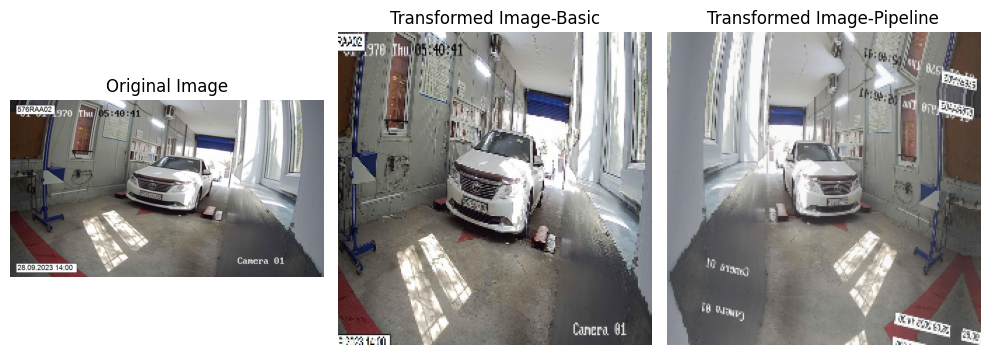

In [19]:
image_path = dts_folder+"test/"+ "70468670.jpeg"
image = Image.open(image_path)

transform = aug_basic_test
image_np = np.array(image)
transformed_image = transform(image=image_np)['image']

transform1 = aug_pipe_test
image_np1 = np.array(image)
transformed_image1 = transform1(image=image_np1)['image']

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Transformed Image-Basic')
plt.imshow(transformed_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Transformed Image-Pipeline')
plt.imshow(transformed_image1)
plt.axis('off')

plt.tight_layout()
plt.show()

# Loading Images and Preparing the Data

In [ ]:
def load_train_images_from_folder(folder):
    folder = os.path.join(folder,"train")
    images = []
    labels = []
    for dir in os.listdir(folder):
        for sub_dir in os.listdir(os.path.join(folder,dir)):
            for filename in os.listdir(os.path.join(folder,dir, sub_dir)):
                image_path = os.path.join(folder,dir, sub_dir, filename)
                label = 1 if int(sub_dir.split('-')[0]) > 0 else 0
                image = Image.open(image_path)
                augmented = aug_pipe(image=np.array(image))
                augmented_image = augmented['image']
                image = aug_basic(image=np.array(image))
                image = image['image']
                images.append(image)
                labels.append(label)
                del image
                images.append(augmented_image)
                labels.append(label)
                del augmented_image
                # augmented = aug_pipe(image=np.array(image))
                # augmented_image = augmented['image']
                # images.append(augmented_image)
                # labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
x_train, y_train = load_train_images_from_folder(dts_folder)
print(x_train.shape, y_train.shape)

(13170, 224, 224, 3) (13170,)


In [ ]:
from sklearn.model_selection import train_test_split

val_split = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=y_train)


X = np.concatenate((x_train, x_val))
del x_train, x_val
y = np.concatenate((y_train, y_val))
del y_train, y_val


# Defining the Model

In [ ]:
conv_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
model = Sequential([
    conv_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [ ]:
history = model.fit(
    X, y,
    epochs=20,
    batch_size = 64,
    validation_split=val_split,
    callbacks=[es],
)

# Saving Results

In [ ]:
res = pd.read_csv("/content/gdrive/MyDrive/Datasaur/test.csv", header=0)
res['class'] = None

for inx, row in res.iterrows():
  id_value = row['file_index']
  img_path = os.path.join(dts_folder, "test", str(id_value)+".jpeg")
  image = Image.open(img_path)
  aug_test = aug_basic(image=np.array(image))
  aug_img = aug_test['image']
  aug_img = aug_img.reshape(1, aug_img.shape[0],aug_img.shape[1],aug_img.shape[2])
  pred = model.predict(aug_img, verbose=0)
  pred = (pred>0.5).astype(int)
  res.at[inx,'class'] = pred[0][0]



In [ ]:
res.head()

In [ ]:
res.to_csv("out_1023_colab.csv",index=False)

In [ ]:
model.save("model_2255_0129.keras")




| Model | Loss | Accuracy |
| --- | --- | --- |
| VGG16 | 0.851 | 0.9436 |
| Xception | 1.268 | 0.8981 |
| ResNet50 | 1.09 | 0.9356 |
| EfficientNetB0 | 0.984 | 0.9289 |
| EfficientNetB1 | 0.967 | 0.9493 |
| EfficientNetB2 | 0.973 | 0.9579 |